# Trabajo Práctico 1 - Modelos de Regresión
## <center> Grupo 07 </center>
### <center> Integrantes: </center>
<center>

Leandro Elias Brizuela

José Rafael Patty Morales

Jesabel Pugliese

Candela Matelica

</center>

# Inicialización del entorno

In [1]:
# Manipulación de datos y funciones matemáticas
import pandas as pd
import numpy as np
import scipy.stats as stats

# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as psp
from IPython.display import display

# Importación de datos
import pyarrow.parquet as pq

# Imputación de datos faltantes
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Normalización
from sklearn.preprocessing import StandardScaler

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# Guardar modelos
import joblib

# Importación de datos

Se trabajará sobre un subconjunto de datos de oferta de hospedaje en la plataforma AirBnB en Los Angeles.

In [2]:
df_airbnb_LA = pd.read_csv('/content/listings.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/listings.csv'

# Exploración de datos

In [ ]:
# Visualizamos la cantidad de filas y columnas del dataframe:

shape_base = df_airbnb_LA.shape
print("Cantidad de filas: ", shape_base[0])
print("Cantidad de columnas: ", shape_base[1])

Cantidad de filas:  45421
Cantidad de columnas:  79


In [ ]:
# Visualizamos las distintas columnas del dataframe y su tipo de datos:

df_airbnb_LA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45421 entries, 0 to 45420
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            45421 non-null  int64  
 1   listing_url                                   45421 non-null  object 
 2   scrape_id                                     45421 non-null  int64  
 3   last_scraped                                  45421 non-null  object 
 4   source                                        45421 non-null  object 
 5   name                                          45420 non-null  object 
 6   description                                   44399 non-null  object 
 7   neighborhood_overview                         20350 non-null  object 
 8   picture_url                                   45421 non-null  object 
 9   host_id                                       45421 non-null 

In [ ]:
# Visualizamos algunas filas del dataframe:

pd.concat([df_airbnb_LA.head(2), df_airbnb_LA.tail(2)])

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2708,https://www.airbnb.com/rooms/2708,20250617032927,2025-06-17,city scrape,"Run Runyon, Beaut Furn Mirror Mini-Suit w/ Fir...",Run Runyon Canyon<br /><br />Gym & Sauna <br /...,"Walk and run to Runyon Canyon, it is open!<br ...",https://a0.muscache.com/pictures/hosting/Hosti...,3008,...,4.98,4.95,4.86,NaN,t,2,0,2,0,0.33
1,2732,https://www.airbnb.com/rooms/2732,20250617032927,2025-06-17,city scrape,Zen Life at the Beach,An oasis of tranquility awaits you.,"This is the best part of Santa Monica. Quiet, ...",https://a0.muscache.com/pictures/1082993/c5a99...,3041,...,4.48,4.91,4.22,228269,f,2,1,1,0,0.14
45419,1443449500529637549,https://www.airbnb.com/rooms/1443449500529637549,20250617032927,2025-06-17,city scrape,Point Dume Summer Rental,Relax with the whole family at this peaceful p...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,115170752,...,NaN,NaN,NaN,STR22-0034,t,2,2,0,0,NaN
45420,1443465434447227262,https://www.airbnb.com/rooms/1443465434447227262,20250617032927,2025-06-17,city scrape,"SoCal Getaway Minutes from Disneyland, DTLA &C...",Stay at this centrally located getaway on the ...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,30071757,...,NaN,NaN,NaN,NaN,t,2,1,0,1,NaN


El objetivo del ejercicio es predecir el
precio de alquiler (price) en función de la información publicada en los avisos.

Realizando un análisis de los datos, descartamos aquellos almacenados que no son relevantes para el objetivo del ejercicio. De esta manera, nos quedamos con las siguientes variables:

- ***neighbourhood_cleansed*** *(categórica)*:  
Vecindario donde está ubicado el alojamiento. Éste se geocodifica usando la latitud y longitud, comparándolas con los vecindarios definidos por shapefiles digitales abiertos o públicos.  
- ***property_type*** *(categórica)*:  
Tipo de propiedad autoelegido. Los hoteles y los *bed and breakfast* son descritos como tales por sus anfitriones en este campo.  
- ***room_type*** *(categórica)*:  
[Entire home/apt | Private room | Shared room | Hotel]  
Todas las viviendas se agrupan en los siguientes tres tipos de habitación:  
  - Entire place (Casa completa)
  - Private room (Habitaciones privadas)
  - Shared room (Habitaciones compartidas)  
- ***accommodates*** *(cuantitativa discreta)*:  
La máxima capacidad del hospedaje.  
- ***bathrooms*** *(cuantitativa discreta)*:  
La cantidad de baños del hospedaje. En general toma valores como $0.5$, $1$, $1.5$, etc. representando un entero como un baño completo que incluye inodoro, lavabo y ducha o bañera, y medio como un baño de servicios que incluye solo inodoro y lavabo, sin ducha ni bañera.  
- ***bathrooms_text*** *(categórica)*:  
La cantidad de baños del hospedaje. En el sitio web de Airbnb, el campo de baños ha evolucionado de un número a una descripción textual.  
- ***bedrooms*** *(cuantitativa discreta)*:  
La cantidad de dormitorios del hospedaje.  
- ***beds*** *(cuantitativa discreta)*:  
La cantidad de camas del hospedaje.  
- ***amenities*** *(categórica)*  
- ***price*** *(cuantitativa continua)*:  
Precio diario en la moneda local.
- ***minimum_nights*** *(cuantitativa discreta)*:  
Número mínimo de noches de estadía para el anuncio (las reglas del calendario pueden ser diferentes).  
- ***maximum_nights*** *(cuantitativa discreta)*:  
Número máximo de noches de estadía para el anuncio (las reglas del calendario pueden ser diferentes).  
- ***review_scores_rating*** *(cuantitativa continua)*:  
Puntuación general o promedio que los huéspedes le dan al alojamiento.
- ***review_scores_value*** *(cuantitativa continua)*:  
Puntuación que los huéspedes le dan a la relación calidad-precio.  



In [ ]:
columnas = ["neighbourhood_cleansed", "property_type", "room_type", "accommodates",
            "bathrooms", "bathrooms_text", "bedrooms", "beds", "amenities",
            "price", "minimum_nights", "maximum_nights", "review_scores_rating",
            "review_scores_value"]

df_airbnb_LA_filtrado = df_airbnb_LA.copy()
df_airbnb_LA_filtrado = df_airbnb_LA_filtrado[columnas]

df_airbnb_LA_filtrado.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45421 entries, 0 to 45420
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neighbourhood_cleansed  45421 non-null  object 
 1   property_type           45421 non-null  object 
 2   room_type               45421 non-null  object 
 3   accommodates            45421 non-null  int64  
 4   bathrooms               36588 non-null  float64
 5   bathrooms_text          45367 non-null  object 
 6   bedrooms                42358 non-null  float64
 7   beds                    36545 non-null  float64
 8   amenities               45421 non-null  object 
 9   price                   36405 non-null  object 
 10  minimum_nights          45421 non-null  int64  
 11  maximum_nights          45421 non-null  int64  
 12  review_scores_rating    32849 non-null  float64
 13  review_scores_value     32831 non-null  float64
dtypes: float64(5), int64(3), object(6)
mem

In [ ]:
# Visualizamos algunas filas del dataframe filtrado:

pd.concat([df_airbnb_LA_filtrado.head(2), df_airbnb_LA_filtrado.tail(2)])

,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_value
0,Hollywood,Private room in rental unit,Private room,1,1.0,1 shared bath,1.0,1.0,"[""Extra pillows and blankets"", ""Frigidaire gas...",$110.00,30,550,4.86,4.86
1,Santa Monica,Private room in rental unit,Private room,1,1.0,1 private bath,1.0,1.0,"[""Host greets you"", ""Free street parking"", ""Re...",$118.00,7,27,4.41,4.22
45419,Malibu,Entire home,Entire home/apt,5,2.0,2 baths,2.0,2.0,"[""Stove"", ""Outdoor furniture"", ""Free parking o...",$479.00,3,365,NaN,NaN
45420,Hawaiian Gardens,Entire condo,Entire home/apt,10,2.0,2 baths,2.0,1.0,"[""Pets allowed"", ""Carbon monoxide alarm"", ""Was...",$169.00,1,365,NaN,NaN


# Generación de nuevas variables

#### `neighbourhood_cleansed`

Veamos cuántos valores únicos tiene la variable `neighbourhood_cleansed`:

In [ ]:
print(len(df_airbnb_LA_filtrado["neighbourhood_cleansed"].unique()))

266


Como tiene muchos valores únicos, entonces al momento de codificarlos con One Hot Encoding se generarían demasiadas columnas. Es por ello que decidimos generar una nueva variable categórica `area` que agrupe barrios según la zona de Los Angeles en que se encuentren.

In [ ]:
def group_neighborhoods(neighborhood):
  # 1. Santa Clarita Valley
  santa_clarita_valley = [
      "Santa Clarita", "Stevenson Ranch", "Castaic", "Castaic Canyons",
      "Acton", "Agua Dulce", "Val Verde", "Lake Hughes",
      "Northeast Antelope Valley", "Northwest Antelope Valley",
      "Sun Village", "Lake Los Angeles", "Elizabeth Lake",
      "Lopez/Kagel Canyons", "Ridge Route", "Hasley Canyon",
      "Unincorporated Santa Susana Mountains",
      "Angeles Crest", "Hidden Hills", "Green Valley"]

  # 2. Antelope Valley
  antelope_valley = [
      "Lancaster", "Palmdale", "Quartz Hill", "Leona Valley",
      "Southeast Antelope Valley", "Northwest Palmdale", "Desert View Highlands"]

  # 3. San Fernando Valley
  san_fernando_valley = [
      "North Hollywood", "Valley Village", "Sherman Oaks", "Studio City",
      "Encino", "Tarzana", "Van Nuys", "Panorama City", "Valley Glen",
      "West Hills", "Northridge", "Canoga Park", "Woodland Hills",
      "Reseda", "Toluca Lake", "Porter Ranch", "Sun Valley", "Tujunga",
      "Tujunga Canyons", "Lake Balboa", "North Hills", "Chatsworth",
      "Chatsworth Reservoir", "Topanga", "Burbank", "Glendale", "Shadow Hills",
      "Sylmar", "Granada Hills", "Winnetka", "Sunland", "Mission Hills",
      "Sepulveda Basin", "San Fernando", "La Crescenta-Montrose", "Pacoima",
      "Lake View Terrace"]

  # 4. San Gabriel Valley
  san_gabriel_valley = [
      "Pasadena", "South Pasadena", "Altadena", "Monrovia", "Arcadia",
      "La Canada Flintridge", "San Gabriel", "Alhambra", "Monterey Park",
      "Rosemead", "San Marino", "Temple City", "East San Gabriel",
      "South San Gabriel", "Covina", "Glendora", "La Verne", "Charter Oak",
      "Baldwin Park", "Irwindale", "North El Monte", "Avocado Heights",
      "El Monte", "West Puente Valley", "Hacienda Heights", "Diamond Bar",
      "Walnut", "La Puente", "Rowland Heights", "West Covina", "Pomona",
      "Azusa", "Claremont", "Citrus", "San Dimas", "Sierra Madre",
      "Duarte", "La Habra Heights", "South San Jose Hills", "Valinda",
      "South El Monte", "Mayflower Village", "North Whittier", "East Whittier",
      "Santa Fe Springs", "Industry", "Artesia", "Cerritos", "East Pasadena",
      "Walnut Park", "San Pasqual", "Vincent", "South Diamond Bar"]


  # 5. Westside Cities
  westside_cities = [
      "Santa Monica", "Venice", "Beverly Hills", "West Los Angeles",
      "Westwood", "Century City", "Brentwood", "Pacific Palisades",
      "Mar Vista", "Playa Vista", "Marina del Rey", "Culver City",
      "Sawtelle", "Cheviot Hills", "Rancho Park", "Palms",
      "Beverly Crest", "Bel-Air", "Malibu", "Westlake Village",
      "Agoura Hills", "Unincorporated Santa Monica Mountains", "Del Rey",
      "Carthay", "Playa del Rey", "Calabasas", "Pico-Robertson", "Westchester",
      "Ladera Heights", "Leimert Park", "Westlake", "Arlington Heights",
      "Baldwin Hills/Crenshaw"]

  # 6. Central LA
  central_la = [
      "Hollywood", "West Hollywood", "Hollywood Hills", "Hollywood Hills West",
      "East Hollywood", "Silver Lake", "Los Feliz", "Koreatown", "Mid-City",
      "Mid-Wilshire", "Hancock Park", "Larchmont", "Beverly Grove",
      "Elysian Valley", "Griffith Park", "Mount Washington", "Lincoln Heights",
      "Chinatown", "Echo Park", "Montecito Heights", "Jefferson Park",
      "University Park", "Adams-Normandie", "Harvard Heights",
      "Vermont Square", "Vermont-Slauson", "Vermont Vista", "Central-Alameda",
      "Chesterfield Square", "South Park", "Exposition Park",
      "Florence-Firestone", "Florence", "Watts", "Historic South-Central",
      "Harvard Park", "Highland Park", "Atwater Village", "Fairfax",
      "Broadway-Manchester", "View Park-Windsor Hills",
      "Downtown", "Beverlywood", "Glassell Park", "Windsor Square",
      "Boyle Heights", "Pico-Union", "Gramercy Park", "Cypress Park",
      "Manchester Square", "Elysian Park", "Vermont Knolls", "Green Meadows",
      "West Adams", "Hyde Park", "Universal City",
      "Veterans Administration", "Westmont", "Athens",
      "Eagle Rock", "East Los Angeles", "Arleta", "El Sereno", "East Pasadena"]

  # 7. Gateway Cities
  gateway_cities = [
      "Bellflower", "Lynwood", "Long Beach", "Inglewood", "Hawthorne",
      "Montebello", "Pico Rivera", "Whittier", "Willowbrook", "South Whittier",
      "Rancho Dominguez", "Bell", "Bell Gardens", "Cudahy", "Commerce",
      "Downey", "Norwalk", "Paramount", "South Gate", "Huntington Park",
      "Maywood", "Vernon", "West Compton", "Compton", "East Compton",
      "West Carson", "Carson", "Alondra Park", "Lawndale", "Gardena", "Lennox",
      "La Mirada", "Hawaiian Gardens", "West Whittier-Los Nietos", "Lakewood",
      "Signal Hill"]

  # 8. South Bay
  south_bay = [
      "Manhattan Beach", "Redondo Beach", "Hermosa Beach", "Torrance",
      "El Segundo", "Rancho Palos Verdes", "Palos Verdes Estates",
      "Rolling Hills", "Rolling Hills Estates", "Lomita", "Del Aire",
      "Harbor City", "San Pedro", "Harbor Gateway", "Wilmington"]

  # 9. Santa Catalina Island
  santa_catalina_island = [
      "Unincorporated Catalina Island", "Avalon"]

  if neighborhood in central_la:
      return "Central LA"
  elif neighborhood in westside_cities:
      return "Westside Cities"
  elif neighborhood in san_fernando_valley:
      return "San Fernando Valley"
  elif neighborhood in santa_clarita_valley:
      return "Santa Clarita Valley"
  elif neighborhood in antelope_valley:
      return "Antelope Valley"
  elif neighborhood in san_gabriel_valley:
      return "San Gabriel Valley"
  elif neighborhood in gateway_cities:
      return "Gateway Cities"
  elif neighborhood in south_bay:
      return "South Bay"
  elif neighborhood in santa_catalina_island:
      return "Santa Catalina Island"

df_airbnb_LA_filtrado["area"] = df_airbnb_LA_filtrado["neighbourhood_cleansed"].apply(group_neighborhoods)
df_airbnb_LA_filtrado.drop(columns=["neighbourhood_cleansed"], axis=1, inplace=True)

In [ ]:
df_airbnb_LA_filtrado["area"].value_counts()

,count
area,
Central LA,14113
Westside Cities,10106
San Gabriel Valley,6438
San Fernando Valley,6369
Gateway Cities,4457
South Bay,2369
Antelope Valley,725
Santa Clarita Valley,588
Santa Catalina Island,256


#### `property_type`

Veamos cuántos valores únicos tiene la variable `property_type`:

In [ ]:
print(len(df_airbnb_LA_filtrado["property_type"].unique()))

94


Como tiene muchos valores únicos, volvemos a generar una nueva variable que agrupe los tipos de propiedad. La llamaremos `property_group`.

In [ ]:
def group_property_types(property_type):
  serviced_apartment_types = [
      "Private room in serviced apartment",
      "Entire serviced apartment",
      "Room in serviced apartment",
      "Room in aparthotel"]

  entire_place_types = [
      "Entire rental unit", "Entire townhouse", "Entire home", "Entire guesthouse",
      "Entire bungalow", "Entire condo", "Entire vacation home", "Tiny home",
      "Entire villa", "Entire guest suite", "Entire cottage", "Entire cabin",
      "Entire loft", "Entire home/apt", "Entire resort", "Entire place", "Floor"]

  private_room_types = [
      "Private room", "Private room in rental unit", "Private room in home",
      "Private room in townhouse", "Private room in condo", "Private room in loft",
      "Private room in treehouse", "Private room in bungalow", "Private room in cottage",
      "Private room in hostel", "Private room in bed and breakfast",
      "Private room in villa", "Private room in guest suite",
      "Private room in guesthouse", "Private room in cabin", "Private room in tent",
      "Private room in farm stay", "Private room in resort", "Private room in yurt",
      "Private room in earthen home", "Private room in tiny home", "Private room in casa particular",
      "Private room in vacation home", "Private room in hut", "Private room in nature lodge",
      "Private room in dome", "Private room in houseboat", "Private room in cave"]

  shared_room_types = [
      "Shared room", "Shared room in hostel", "Shared room in home",
      "Shared room in rental unit", "Shared room in guesthouse", "Shared room in condo",
      "Shared room in townhouse", "Shared room in bed and breakfast",
      "Shared room in hotel", "Shared room in villa", "Shared room in earthen home",
      "Shared room in bungalow", "Shared room in loft"]

  specialty_types = [
      "Camper/RV", "Farm stay", "Ranch", "Treehouse", "Yurt", "Shipping container",
      "Barn", "Boat", "Dome", "Tipi", "Campsite", "Hut", "Shepherd’s hut",
      "Casa particular", "Lighthouse", "Earthen home", "Castle", "Island", "Train",
      "Room in hotel", "Room in boutique hotel", "Room in bed and breakfast",
      "Tower", "Minsu", "Tent", "Houseboat", "Private room in castle",
      "Private room in camper/rv", "Private room in barn", "Room in hostel",
      "Cave", "Bus"]

  if property_type in serviced_apartment_types:
      return "Serviced apartment"
  elif property_type in entire_place_types:
      return "Entire place"
  elif property_type in private_room_types:
      return "Private room"
  elif property_type in shared_room_types:
      return "Shared room"
  elif property_type in specialty_types:
      return "Specialty"

df_airbnb_LA_filtrado["property_group"] = df_airbnb_LA_filtrado["property_type"].apply(group_property_types)
df_airbnb_LA_filtrado.drop(columns=["property_type"], axis=1, inplace=True)

In [ ]:
df_airbnb_LA_filtrado["property_group"].value_counts()

,count
property_group,
Entire place,32521
Private room,10652
Specialty,1493
Serviced apartment,395
Shared room,360


#### `bathrooms_text`

Veamos cuántos valores únicos tiene la variable `bathrooms_text`:

In [ ]:
print(len(df_airbnb_LA_filtrado["bathrooms_text"].unique()))

54


In [ ]:
print("Valores posibles 'bathrooms_text: '", df_airbnb_LA["bathrooms_text"].unique())

Valores posibles 'bathrooms_text: ' ['1 shared bath' '1 private bath' '1 bath' '1.5 baths' '1.5 shared baths'
 '6.5 baths' '2 baths' '2.5 baths' '3.5 baths' '4 baths' '11 shared baths'
 '0 baths' '4.5 baths' '2 shared baths' '3 baths' nan 'Half-bath'
 '3.5 shared baths' '8 shared baths' '8 baths' '3 shared baths'
 '11.5 shared baths' '5 baths' '4.5 shared baths' '7.5 baths'
 '2.5 shared baths' '5.5 baths' '0 shared baths' 'Shared half-bath'
 '8.5 baths' '10 baths' 'Private half-bath' '6 baths' '7 baths' '9 baths'
 '12.5 baths' '9.5 baths' '12 baths' '10.5 baths' '13 baths'
 '5.5 shared baths' '13.5 baths' '24 baths' '4 shared baths' '21 baths'
 '11 baths' '11.5 baths' '6 shared baths' '7 shared baths'
 '5 shared baths' '15 baths' '32.5 baths' '16 baths' '14 baths']


Definimos que la cantidad de baños se encuentre en la variable `bathrooms` y el tipo de baño (*shared* o *private*) en una nueva variable `bathrooms_type`:

In [ ]:
bathrooms_text = df_airbnb_LA_filtrado["bathrooms_text"].copy()
pat = r"(\d+(?:[.,]\d+)?)\s(shared|private)?\sbath(?:room)?s?"
bathrooms_text = bathrooms_text.str.lower().str.extract(pat)
bathrooms_text.columns = ["bathrooms_num", "is_shared"]

df_airbnb_LA_filtrado["bathrooms_type"] = bathrooms_text["is_shared"].fillna("private")
df_airbnb_LA_filtrado.drop(columns=["bathrooms_text"], axis=1, inplace=True)

In [ ]:
df_airbnb_LA_filtrado["bathrooms_type"].value_counts()

,count
bathrooms_type,
private,40531
shared,4890


#### `amenities`

Veamos cuántos `amenities` distintos hay:

In [ ]:
import ast

amenities = set()

for amenity_str in df_airbnb_LA_filtrado["amenities"]:
    amenity_list = ast.literal_eval(amenity_str)
    amenities.update(amenity_list)

print(f"Número de amenities distintos: {len(amenities)}")

Número de amenities distintos: 10546


Creamos una nueva variable `amenities_num` que represente la cantidad de amenities que tiene cada hospedaje:


In [ ]:
df_airbnb_LA_filtrado["amenities_num"] = df_airbnb_LA_filtrado["amenities"].apply(lambda x: len(ast.literal_eval(x)))
df_airbnb_LA_filtrado.drop(columns=["amenities"], axis=1, inplace=True)

#### `price`

In [ ]:
# Convertimos la variable price a numérica

df_airbnb_LA_filtrado["price"] = df_airbnb_LA_filtrado["price"].str.replace('$', '', regex=False)
df_airbnb_LA_filtrado["price"] = df_airbnb_LA_filtrado["price"].str.replace(',', '', regex=False)
df_airbnb_LA_filtrado["price"] = df_airbnb_LA_filtrado["price"].astype(float)

# Limpieza de los datos

## Tratamiento de valores atípicos

In [ ]:
total_outliers_eliminados = 0

### Análisis univariado

Se construirán box plots por variable a fin de identificar y comparar la presencia de valores atípicos.  
Las variables a analizar son: `accommodates`, `bathrooms`, `bathrooms_text`, `bedrooms`, `beds`, `price`, `minimum_nights`, `maximum_nights`, `review_scores_rating`, y `review_scores_value`.

#### `accommodates`

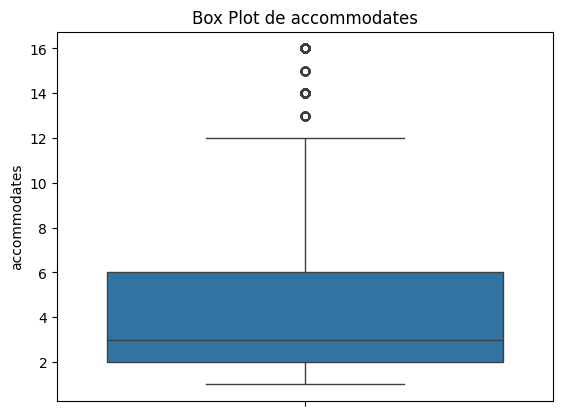

In [ ]:
# Graficamos el Box Plot de la variable accommodates:
sns.boxplot(
    data = df_airbnb_LA_filtrado,
    y = 'accommodates'
).set(ylabel = "accommodates", title = "Box Plot de accommodates")
plt.show()

La variable `accommodates` no pareciera tener valores atípicos univariados, pero será necesario reexaminarla en comparación con otras variables.

#### `bathrooms`

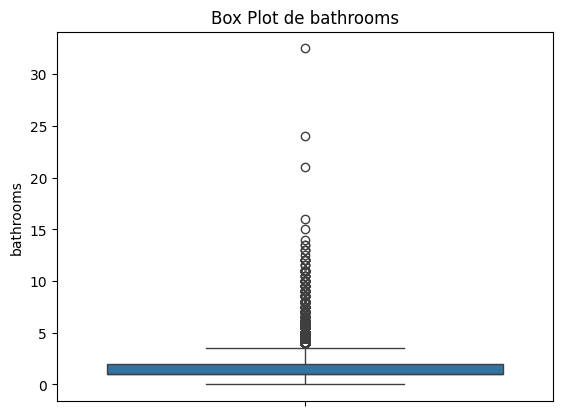

In [ ]:
# Graficamos el Box Plot de la variable bathrooms:
sns.boxplot(
    data = df_airbnb_LA_filtrado,
    y = 'bathrooms'
).set(ylabel = "bathrooms", title = "Box Plot de bathrooms")
plt.show()

A pesar de que los valores que toma la variable bathrooms pueden ser valores posibles, hay algunos que son muy grandes que se alejan de la mayoría, por lo que decidimos eliminarlos. En particular, borramos aquellos valores que sobrepasen el percentil $95\%$.

In [ ]:
percentil = df_airbnb_LA_filtrado["bathrooms"].quantile(0.99)
print(f"Percentil 99% de 'bathrooms': {percentil:2f}")

Percentil 99% de 'bathrooms': 6.500000


In [ ]:
num_outliers_bathrooms = (df_airbnb_LA_filtrado["bathrooms"] > percentil).sum()
total_outliers_eliminados += num_outliers_bathrooms
df_airbnb_LA_filtrado = df_airbnb_LA_filtrado[
    (df_airbnb_LA_filtrado["bathrooms"] <= percentil) | (df_airbnb_LA_filtrado["bathrooms"].isna())]
df_airbnb_LA_filtrado.reset_index(drop=True, inplace=True)
print("Cantidad de outliers de 'bathrooms' eliminados: ", num_outliers_bathrooms)

Cantidad de outliers de 'bathrooms' eliminados:  324


Consideramos el valor 0 como valor atípico, pues no tiene sentido que un hospedaje tenga 0 baños, por lo que el tratamiento para estos datos será eliminarlos:

In [ ]:
num_outliers_bathrooms = (df_airbnb_LA_filtrado["bathrooms"] == 0).sum()
total_outliers_eliminados += num_outliers_bathrooms
df_airbnb_LA_filtrado = df_airbnb_LA_filtrado[
    (df_airbnb_LA_filtrado["bathrooms"] != 0) | (df_airbnb_LA_filtrado["bathrooms"].isna())]
df_airbnb_LA_filtrado.reset_index(drop=True, inplace=True)
print("Cantidad de outliers de 'bathrooms' eliminados: ", num_outliers_bathrooms)

Cantidad de outliers de 'bathrooms' eliminados:  147


#### `bedrooms`

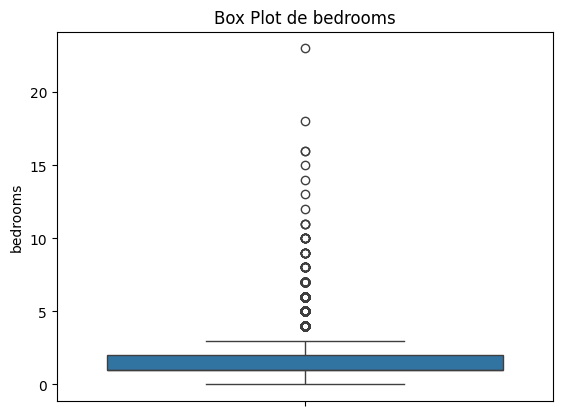

In [ ]:
# Graficamos el Box Plot de la variable bedrooms:
sns.boxplot(
    data = df_airbnb_LA_filtrado,
    y = 'bedrooms'
).set(ylabel = "bedrooms", title = "Box Plot de bedrooms")
plt.show()

In [ ]:
percentil = df_airbnb_LA_filtrado["bedrooms"].quantile(0.99)
print(f"Percentil 99% de 'bedrooms': {percentil:2f}")

Percentil 99% de 'bedrooms': 5.000000


In [ ]:
num_outliers_bedrooms = (df_airbnb_LA_filtrado["bedrooms"] > percentil).sum()
total_outliers_eliminados += num_outliers_bedrooms
df_airbnb_LA_filtrado = df_airbnb_LA_filtrado[
    (df_airbnb_LA_filtrado["bedrooms"] <= percentil) | (df_airbnb_LA_filtrado["bedrooms"].isna())]
df_airbnb_LA_filtrado.reset_index(drop=True, inplace=True)
print("Cantidad de outliers de 'bedrooms' eliminados: ", num_outliers_bedrooms)

Cantidad de outliers de 'bedrooms' eliminados:  417


#### `beds`

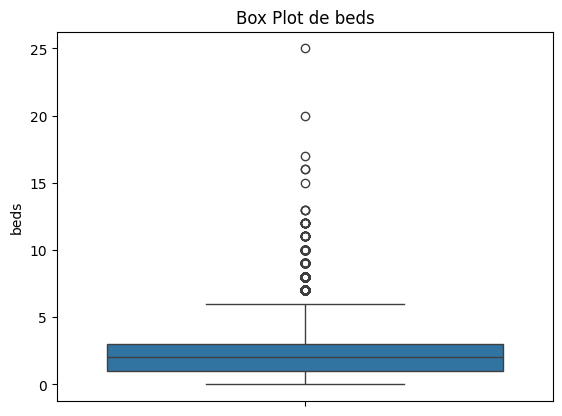

In [ ]:
# Graficamos el Box Plot de la variable beds:
sns.boxplot(
    data = df_airbnb_LA_filtrado,
    y = 'beds'
).set(ylabel = "beds", title = "Box Plot de beds")
plt.show()

In [ ]:
percentil = df_airbnb_LA_filtrado["beds"].quantile(0.99)
print(f"Percentil 99% de 'beds': {percentil:2f}")

Percentil 99% de 'beds': 7.000000


In [ ]:
num_outliers_beds = (df_airbnb_LA_filtrado["beds"] > percentil).sum()
total_outliers_eliminados += num_outliers_beds
df_airbnb_LA_filtrado = df_airbnb_LA_filtrado[
    (df_airbnb_LA_filtrado["beds"] <= percentil) | (df_airbnb_LA_filtrado["beds"].isna())]
df_airbnb_LA_filtrado.reset_index(drop=True, inplace=True)
print("Cantidad de outliers de 'beds' eliminados: ", num_outliers_beds)

Cantidad de outliers de 'beds' eliminados:  284


Consideramos el valor 0 como valor atípico, pues no tiene sentido que un hospedaje tenga 0 camas, por lo que el tratamiento para estos datos será eliminarlos:

In [ ]:
num_outliers_beds = (df_airbnb_LA_filtrado["beds"] == 0).sum()
total_outliers_eliminados += num_outliers_beds
df_airbnb_LA_filtrado = df_airbnb_LA_filtrado[
    (df_airbnb_LA_filtrado["beds"] != 0) | (df_airbnb_LA_filtrado["beds"].isna())]
df_airbnb_LA_filtrado.reset_index(drop=True, inplace=True)
print("Cantidad de outliers de 'beds' eliminados: ", num_outliers_beds)

Cantidad de outliers de 'beds' eliminados:  538


#### `price`

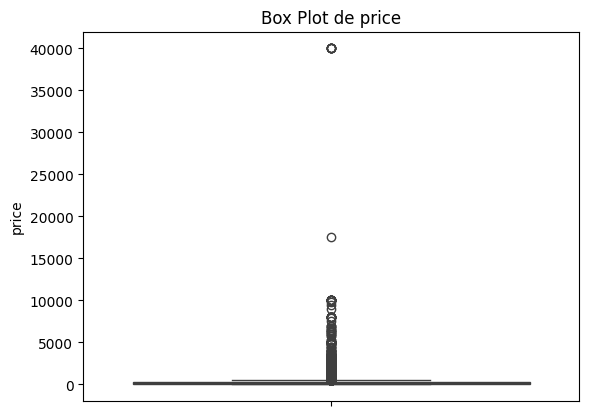

In [ ]:
# Graficamos el Box Plot de la variable price:
sns.boxplot(
    data = df_airbnb_LA_filtrado,
    y = 'price'
).set(ylabel = "price", title = "Box Plot de price")
plt.show()

In [ ]:
percentil = df_airbnb_LA_filtrado["price"].quantile(0.99)
print(f"Percentil 99% de 'price': {percentil:2f}")

Percentil 99% de 'price': 1769.380000


In [ ]:
num_outliers_price = (df_airbnb_LA_filtrado["price"] > percentil).sum()
total_outliers_eliminados += num_outliers_price
df_airbnb_LA_filtrado = df_airbnb_LA_filtrado[
    (df_airbnb_LA_filtrado["price"] <= percentil) | (df_airbnb_LA_filtrado["price"].isna())]
df_airbnb_LA_filtrado.reset_index(drop=True, inplace=True)
print("Cantidad de outliers de 'price' eliminados: ", num_outliers_price)

Cantidad de outliers de 'price' eliminados:  348


Se observa un rango de valores muy cercanos al 0. En caso de que sea este el valor, lo consideramos atípico y eliminamos el dato asociado.

In [ ]:
num_outliers_price = (df_airbnb_LA_filtrado["price"] == 0).sum()
total_outliers_eliminados += num_outliers_price
df_airbnb_LA_filtrado = df_airbnb_LA_filtrado[
    (df_airbnb_LA_filtrado["price"] != 0) | (df_airbnb_LA_filtrado["price"].isna())]
df_airbnb_LA_filtrado.reset_index(drop=True, inplace=True)
print("Cantidad de outliers de 'price' eliminados: ", num_outliers_price)

Cantidad de outliers de 'price' eliminados:  0


#### `minimum_nights`

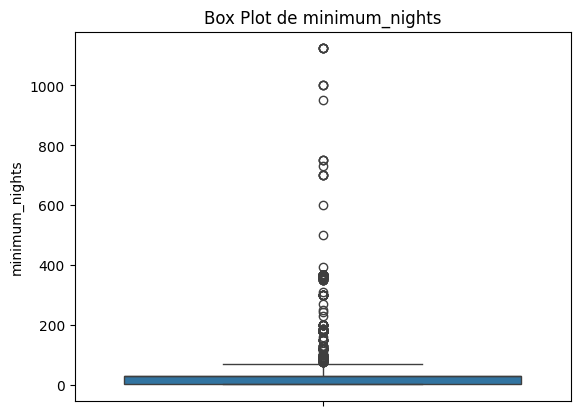

In [ ]:
# Graficamos el Box Plot de la variable minimum_nights:
sns.boxplot(
    data = df_airbnb_LA_filtrado,
    y = 'minimum_nights'
).set(ylabel = "minimum_nights", title = "Box Plot de minimum_nights")
plt.show()

In [ ]:
percentil = df_airbnb_LA_filtrado["minimum_nights"].quantile(0.99)
print(f"Percentil 99% de 'minimum_nights': {percentil:2f}")

Percentil 99% de 'minimum_nights': 90.000000


In [ ]:
num_outliers_minimum_nights = (df_airbnb_LA_filtrado["minimum_nights"] > percentil).sum()
total_outliers_eliminados += num_outliers_minimum_nights
df_airbnb_LA_filtrado = df_airbnb_LA_filtrado[
    (df_airbnb_LA_filtrado["minimum_nights"] <= percentil) | (df_airbnb_LA_filtrado["minimum_nights"].isna())]
df_airbnb_LA_filtrado.reset_index(drop=True, inplace=True)
print("Cantidad de outliers de 'minimum_nights' eliminados: ", num_outliers_minimum_nights)

Cantidad de outliers de 'minimum_nights' eliminados:  358


#### `maximum_nights`

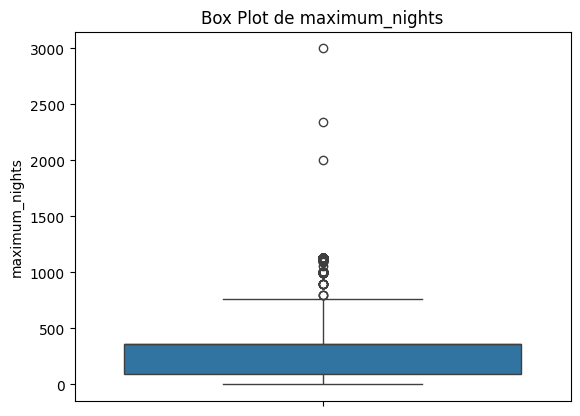

In [ ]:
# Graficamos el Box Plot de la variable maximum_nights:
sns.boxplot(
    data = df_airbnb_LA_filtrado,
    y = 'maximum_nights'
).set(ylabel = "maximum_nights", title = "Box Plot de maximum_nights")
plt.show()

In [ ]:
percentil = df_airbnb_LA_filtrado["maximum_nights"].quantile(0.99)
print(f"Percentil 99% de 'maximum_nights': {percentil:2f}")

Percentil 99% de 'maximum_nights': 1125.000000


In [ ]:
num_outliers_maximum_nights = (df_airbnb_LA_filtrado["maximum_nights"] > percentil).sum()
total_outliers_eliminados += num_outliers_maximum_nights
df_airbnb_LA_filtrado = df_airbnb_LA_filtrado[
    (df_airbnb_LA_filtrado["maximum_nights"] <= percentil) | (df_airbnb_LA_filtrado["maximum_nights"].isna())]
df_airbnb_LA_filtrado.reset_index(drop=True, inplace=True)
print("Cantidad de outliers de 'maximum_nights' eliminados: ", num_outliers_maximum_nights)

Cantidad de outliers de 'maximum_nights' eliminados:  3


#### `review_scores_rating`

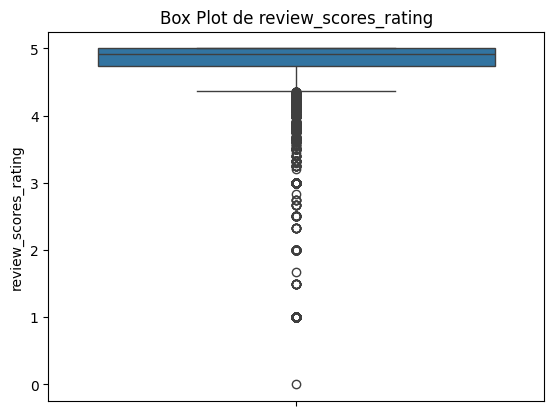

In [ ]:
# Graficamos el Box Plot de la variable review_scores_rating:
sns.boxplot(
    data = df_airbnb_LA_filtrado,
    y = 'review_scores_rating'
).set(ylabel = "review_scores_rating", title = "Box Plot de review_scores_rating")
plt.show()

Para esta variable no se encontraron valores atípicos.

#### `review_scores_value`

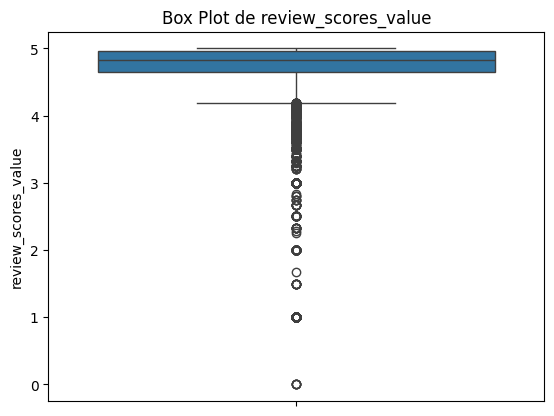

In [ ]:
# Graficamos el Box Plot de la variable review_scores_value:
sns.boxplot(
    data = df_airbnb_LA_filtrado,
    y = 'review_scores_value'
).set(ylabel = "review_scores_value", title = "Box Plot de review_scores_value")
plt.show()

Para esta variable no se encontraron valores atípicos.

### Análisis multivariado

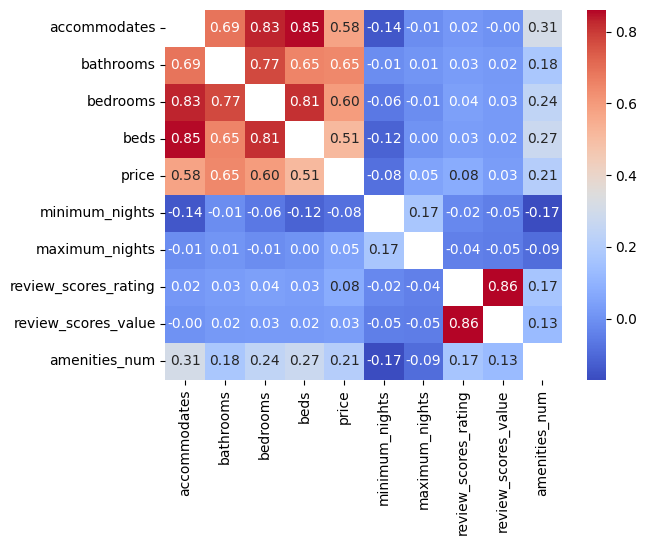

<Figure size 1500x800 with 0 Axes>

In [ ]:
# Graficamos la Matriz de Correlación en un Heatmap

matriz_correlacion = df_airbnb_LA_filtrado.corr(numeric_only=True)
diagonal = np.eye(len(matriz_correlacion), dtype=bool)
sns.heatmap(matriz_correlacion, mask=diagonal, annot=True, fmt=".2f", cmap='coolwarm')
plt.figure(figsize = (15,8))
plt.show()

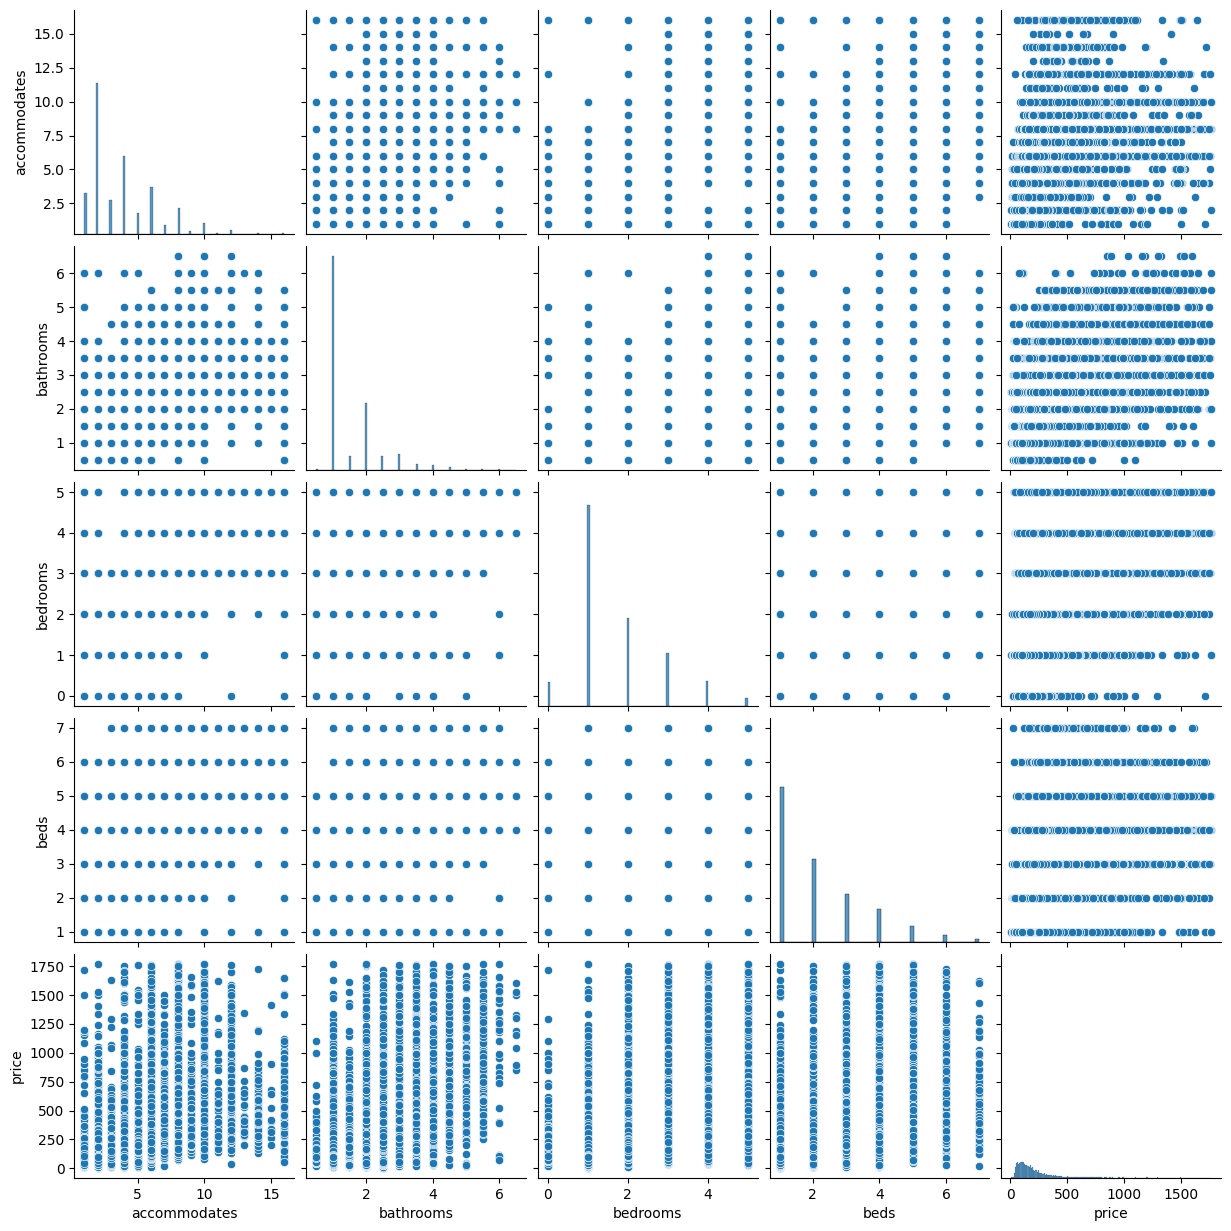

In [ ]:
# Realizamos un Pair Plot para analizar cómo se correlacionan las variables

columnas = ["accommodates", "bathrooms", "bedrooms", "beds", "price"]
df_pair_plot = df_airbnb_LA_filtrado[columnas]
sns.pairplot(df_pair_plot)
plt.show()

Detectamos los valores atípicos mediante análisis de ambos gráficos. Aquellos valores que no se aproximen a la distribución de la mayoría serán considerados atípicos. El análisis será hecho mediante el cálculo de las distancias de Mahalanobis.  

In [ ]:
def mahalanobis_distance(df, columns):
  df_columns = df[columns].copy()
  df_columns = df_columns.dropna()
  df_columns.drop_duplicates(inplace=True)

  # Calculo el vector de medias
  vmedias = np.mean(df_columns[columns])

  # Calculo la diferencia entre las observaciones y el vector de medias
  x_dif = df_columns[columns] - vmedias

  # Calculo matriz de covarianza y su inversa
  cov = df_columns[columns].cov().values
  inv_cov = np.linalg.inv(cov)

  # Calculamos el cuadrado de la distancia de mahalanobis
  mahal = np.dot(np.dot(x_dif, inv_cov), x_dif.T)

  df_columns["mahalanobis"] = mahal.diagonal()

  return df_columns

#### `accommodates` y `beds`



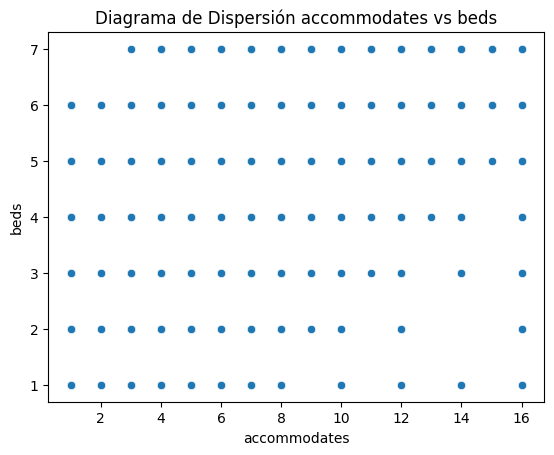

In [ ]:
df_accommodates_beds = df_airbnb_LA_filtrado[["accommodates", "beds"]].copy()
sns.scatterplot(x=df_accommodates_beds["accommodates"], y=df_accommodates_beds["beds"])
plt.title("Diagrama de Dispersión accommodates vs beds")
plt.show()

In [ ]:
df_accommodates_beds = mahalanobis_distance(df_airbnb_LA_filtrado, ["accommodates", "beds"])
df_accommodates_beds["mahalanobis"].describe()

,mahalanobis
count,99.000000
mean,3.387627
std,2.904929
min,0.006057
25%,1.128985
50%,2.795139
75%,4.904786
max,13.933562


In [ ]:
percentil = df_accommodates_beds["mahalanobis"].quantile(0.950)
print(f"Tomaremos el percentil 95% como umbral, lo que corresponde a un valor de {percentil:.2f}")

Tomaremos el percentil 95% como umbral, lo que corresponde a un valor de 8.64


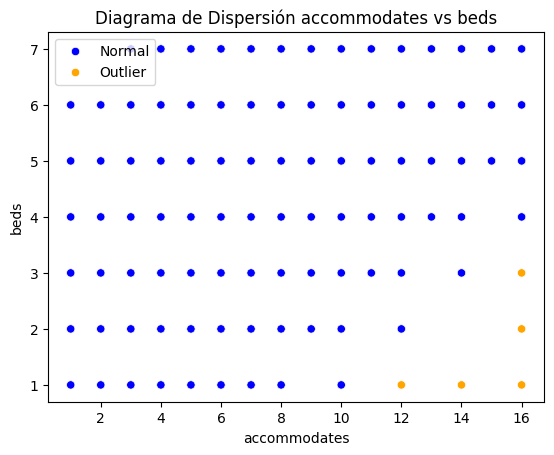

In [ ]:
labels_accommodates_beds = ["Normal" if x <= percentil else "Outlier" for x in df_accommodates_beds["mahalanobis"]]
sns.scatterplot(x=df_accommodates_beds["accommodates"], y=df_accommodates_beds["beds"],
                hue=labels_accommodates_beds,
                palette={"Normal": "blue", "Outlier": "orange"})
plt.title("Diagrama de Dispersión accommodates vs beds")
plt.show()

In [ ]:
outliers_values = df_accommodates_beds[df_accommodates_beds["mahalanobis"] > percentil]

outliers = df_airbnb_LA_filtrado.merge(
    outliers_values[["accommodates", "beds"]],
    on=["accommodates", "beds"],
    how="inner"
)

# Eliminamos del dataset las filas que coincidan con los outliers
df_airbnb_LA_filtrado = df_airbnb_LA_filtrado.merge(
    outliers[["accommodates", "beds"]],
    on=["accommodates", "beds"],
    how="left",
    indicator=True
).query('_merge == "left_only"').drop(columns="_merge")

df_airbnb_LA_filtrado.reset_index(drop=True, inplace=True)
print("Cantidad de outliers eliminados: ", outliers.shape[0])
total_outliers_eliminados += outliers.shape[0]

Cantidad de outliers eliminados:  24


#### `accommodates` y `bedrooms`

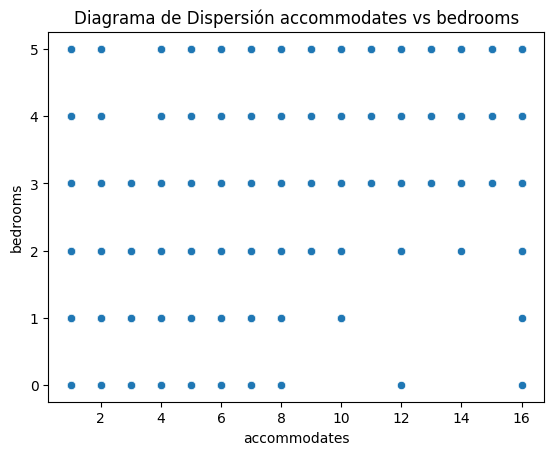

In [ ]:
df_accommodates_bedrooms = df_airbnb_LA_filtrado[["accommodates", "bedrooms"]].copy()
sns.scatterplot(x=df_accommodates_bedrooms["accommodates"], y=df_accommodates_bedrooms["bedrooms"])
plt.title("Diagrama de Dispersión accommodates vs bedrooms")
plt.show()

In [ ]:
df_accommodates_bedrooms = mahalanobis_distance(df_airbnb_LA_filtrado, ["accommodates", "bedrooms"])
df_accommodates_bedrooms["mahalanobis"].describe()

,mahalanobis
count,79.000000
mean,5.210338
std,4.105557
min,0.043509
25%,2.048905
50%,4.339373
75%,7.260583
max,19.816310


In [ ]:
percentil = df_accommodates_bedrooms["mahalanobis"].quantile(0.950)
print(f"Tomaremos el percentil 95% como umbral, lo que corresponde a un valor de {percentil:.2f}")

Tomaremos el percentil 95% como umbral, lo que corresponde a un valor de 11.94


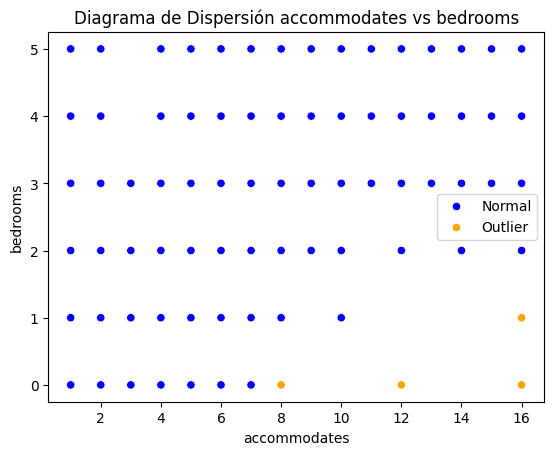

In [ ]:
labels_accommodates_bedrooms = ["Normal" if x <= percentil else "Outlier" for x in df_accommodates_bedrooms["mahalanobis"]]
sns.scatterplot(x=df_accommodates_bedrooms["accommodates"], y=df_accommodates_bedrooms["bedrooms"],
                hue=labels_accommodates_bedrooms,
                palette={"Normal": "blue", "Outlier": "orange"})
plt.title("Diagrama de Dispersión accommodates vs bedrooms")
plt.show()

In [ ]:
outliers_values = df_accommodates_bedrooms[df_accommodates_bedrooms["mahalanobis"] > percentil]

outliers = df_airbnb_LA_filtrado.merge(
    outliers_values[["accommodates", "bedrooms"]],
    on=["accommodates", "bedrooms"],
    how="inner"
)

# Eliminamos del dataset las filas que coincidan con los outliers
df_airbnb_LA_filtrado = df_airbnb_LA_filtrado.merge(
    outliers[["accommodates", "bedrooms"]],
    on=["accommodates", "bedrooms"],
    how="left",
    indicator=True
).query('_merge == "left_only"').drop(columns="_merge")

df_airbnb_LA_filtrado.reset_index(drop=True, inplace=True)
print("Cantidad de outliers eliminados: ", outliers.shape[0])
total_outliers_eliminados += outliers.shape[0]

Cantidad de outliers eliminados:  8


#### `accommodates` y `bathrooms`

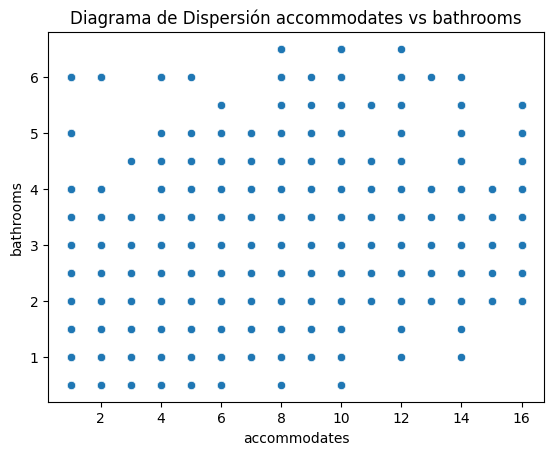

In [ ]:
df_accommodates_bathrooms = df_airbnb_LA_filtrado[["accommodates", "bathrooms"]].copy()
sns.scatterplot(x=df_accommodates_bathrooms["accommodates"], y=df_accommodates_bathrooms["bathrooms"])
plt.title("Diagrama de Dispersión accommodates vs bathrooms")
plt.show()

In [ ]:
df_accommodates_bathrooms = mahalanobis_distance(df_airbnb_LA_filtrado, ["accommodates", "bathrooms"])
df_accommodates_bathrooms["mahalanobis"].describe()

,mahalanobis
count,155.000000
mean,5.075273
std,3.622160
min,0.025994
25%,1.952179
50%,4.464440
75%,7.845252
max,14.655171


In [ ]:
percentil = df_accommodates_bathrooms["mahalanobis"].quantile(0.950)
print(f"Tomaremos el percentil 95% como umbral, lo que corresponde a un valor de {percentil:.2f}")

Tomaremos el percentil 95% como umbral, lo que corresponde a un valor de 11.12


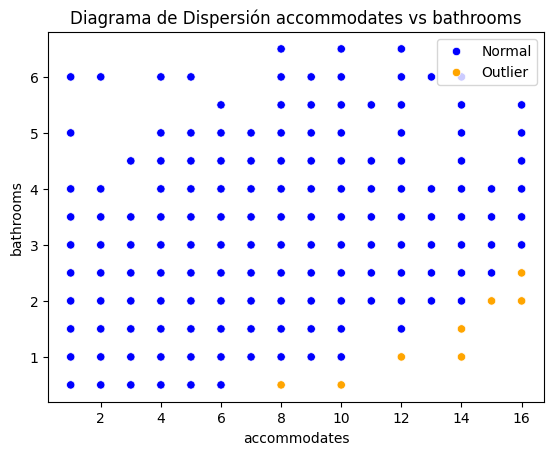

In [ ]:
labels_accommodates_bathrooms = ["Normal" if x <= percentil else "Outlier" for x in df_accommodates_bathrooms["mahalanobis"]]
sns.scatterplot(x=df_accommodates_bathrooms["accommodates"], y=df_accommodates_bathrooms["bathrooms"],
                hue=labels_accommodates_bathrooms,
                palette={"Normal": "blue", "Outlier": "orange"})
plt.title("Diagrama de Dispersión accommodates vs bathrooms")
plt.show()

In [ ]:
outliers_values = df_accommodates_bathrooms[df_accommodates_bathrooms["mahalanobis"] > percentil]

outliers = df_airbnb_LA_filtrado.merge(
    outliers_values[["accommodates", "bathrooms"]],
    on=["accommodates", "bathrooms"],
    how="inner"
)

# Eliminamos del dataset las filas que coincidan con los outliers
df_airbnb_LA_filtrado = df_airbnb_LA_filtrado.merge(
    outliers[["accommodates", "bathrooms"]],
    on=["accommodates", "bathrooms"],
    how="left",
    indicator=True
).query('_merge == "left_only"').drop(columns="_merge")

df_airbnb_LA_filtrado.reset_index(drop=True, inplace=True)
print("Cantidad de outliers eliminados: ", outliers.shape[0])
total_outliers_eliminados += outliers.shape[0]

Cantidad de outliers eliminados:  23


#### `accommodates` y `price`

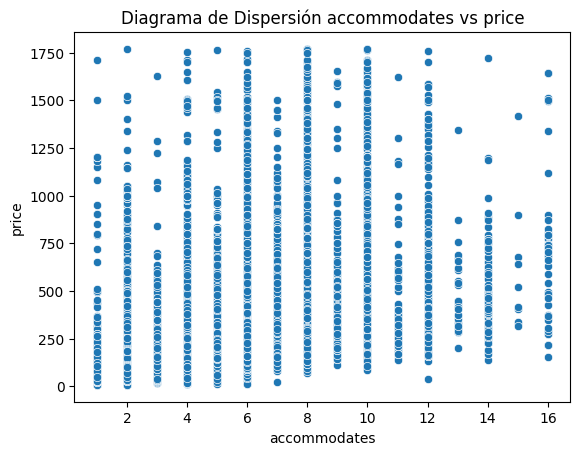

In [ ]:
df_accommodates_price = df_airbnb_LA_filtrado[["accommodates", "price"]].copy()
sns.scatterplot(x=df_accommodates_price["accommodates"], y=df_accommodates_price["price"])
plt.title("Diagrama de Dispersión accommodates vs price")
plt.show()

In [ ]:
df_accommodates_price = mahalanobis_distance(df_airbnb_LA_filtrado, ["accommodates", "price"])
df_accommodates_price["mahalanobis"].describe()

,mahalanobis
count,5339.000000
mean,5902.967820
std,153.404799
min,5383.303661
25%,5805.300188
50%,5918.430910
75%,6018.373873
max,6367.759006


In [ ]:
percentil = df_accommodates_price["mahalanobis"].quantile(0.990)
print(f"Tomaremos el percentil 99% como umbral, lo que corresponde a un valor de {percentil:.2f}")

Tomaremos el percentil 99% como umbral, lo que corresponde a un valor de 6183.94


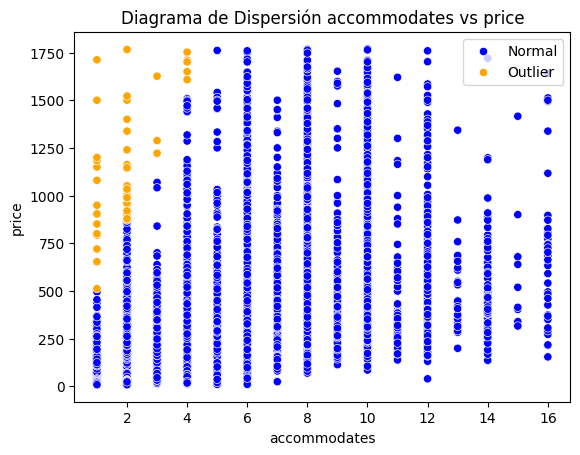

In [ ]:
labels_accommodates_price = ["Normal" if x <= percentil else "Outlier" for x in df_accommodates_price["mahalanobis"]]
sns.scatterplot(x=df_accommodates_price["accommodates"], y=df_accommodates_price["price"],
                hue=labels_accommodates_price,
                palette={"Normal": "blue", "Outlier": "orange"})
plt.title("Diagrama de Dispersión accommodates vs price")
plt.show()

In [ ]:
# outliers_values = df_accommodates_price[df_accommodates_price["mahalanobis"] > percentil]

# outliers = df_airbnb_LA_filtrado.merge(
#     outliers_values[["accommodates", "price"]],
#     on=["accommodates", "price"],
#     how="inner"
# )

# # Eliminamos del dataset las filas que coincidan con los outliers
# df_airbnb_LA_filtrado = df_airbnb_LA_filtrado.merge(
#     outliers[["accommodates", "price"]],
#     on=["accommodates", "price"],
#     how="left",
#     indicator=True
# ).query('_merge == "left_only"').drop(columns="_merge")

# df_airbnb_LA_filtrado.reset_index(drop=True, inplace=True)
# print("Cantidad de outliers eliminados: ", outliers.shape[0])
# total_outliers_eliminados += outliers.shape[0]

#### `minimum_nights` y `maximum_nights`

En este caso consideraremos valores atípicos (o mal cargados) aquellos que no tengan un orden lógico en las noches mínimas (`minimum_nights`) y noches máximas (`maximum_nights`).  

In [ ]:
# Verificamos la cantidad de outliers

(df_airbnb_LA_filtrado['minimum_nights'] > df_airbnb_LA_filtrado['maximum_nights']).sum()

np.int64(1)

Como se trata de un solo valor, analizamos ese caso en particular:

In [ ]:
df_airbnb_LA_filtrado[df_airbnb_LA_filtrado['minimum_nights'] > df_airbnb_LA_filtrado['maximum_nights']]

,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_value,area,property_group,bathrooms_type,amenities_num
27091,Entire home/apt,4,2.0,2.0,2.0,276.0,30,29,5.0,5.0,Central LA,Entire place,private,42


Como los valores de `minimum_nights` y `maximum_nights` son cercanos ($30$ y $29$, respectivamente), decidimos intercambiarlos entre sí para mejorar la coherencia de los datos.

In [ ]:
indice = 26368
old_minimum_nights = df_airbnb_LA_filtrado.at[indice, 'minimum_nights']
df_airbnb_LA_filtrado.at[indice, 'minimum_nights'] = df_airbnb_LA_filtrado.at[indice, 'maximum_nights']
df_airbnb_LA_filtrado.at[indice, 'maximum_nights'] = old_minimum_nights

In [ ]:
df_airbnb_LA_filtrado[df_airbnb_LA_filtrado['minimum_nights'] > df_airbnb_LA_filtrado['maximum_nights']]

,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_value,area,property_group,bathrooms_type,amenities_num
26368,Private room,2,1.0,1.0,1.0,88.0,90,30,NaN,NaN,Central LA,Private room,private,51
27091,Entire home/apt,4,2.0,2.0,2.0,276.0,30,29,5.0,5.0,Central LA,Entire place,private,42


### Conclusión

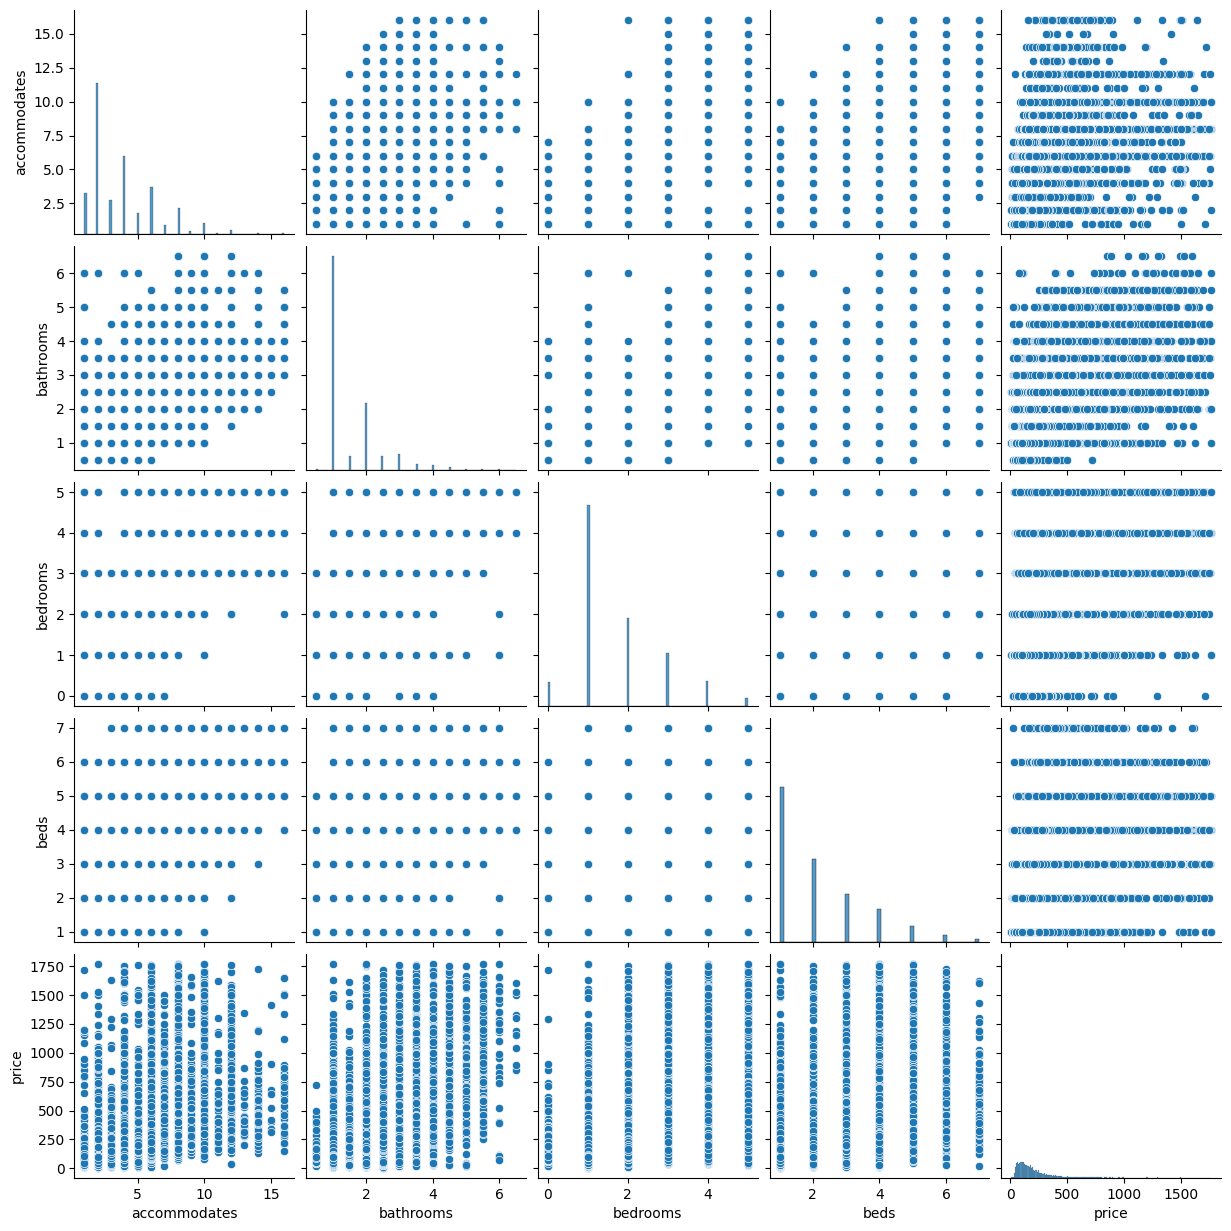

In [ ]:
# Volvemos a realizar un Pair Plot

columnas = ["accommodates", "bathrooms", "bedrooms", "beds", "price"]
df_pair_plot = df_airbnb_LA_filtrado[columnas]
sns.pairplot(df_pair_plot)
plt.show()

Como podemos visualizar en el gráfico, logramos reducir la dispersión de los datos y así la presencia de valores atípicos.  

In [ ]:
porcentaje_outliers_elim = (total_outliers_eliminados / shape_base[0]) * 100
print("Cantidad total de outliers eliminados: ", total_outliers_eliminados)
print(f"Porcentaje de outliers eliminados frente al total de datos del dataset: {porcentaje_outliers_elim:.2f}%")
print(f"El tamaño del dataset se redujo de {shape_base[0]} datos a {df_airbnb_LA_filtrado.shape[0]} datos.")

Cantidad total de outliers eliminados:  2474
Porcentaje de outliers eliminados frente al total de datos del dataset: 5.45%
El tamaño del dataset se redujo de 45421 datos a 42947 datos.


## Tratamiento de datos faltantes

In [ ]:
# Visualizamos la cantidad de datos nulos por columna en el dataframe:

print(df_airbnb_LA_filtrado.isna().sum())

room_type                   0
accommodates                0
bathrooms                8570
bedrooms                 2995
beds                     8611
price                    8744
minimum_nights              0
maximum_nights              0
review_scores_rating    11576
review_scores_value     11589
area                        0
property_group              0
bathrooms_type              0
amenities_num               0
dtype: int64


In [ ]:
# Visualizamos el porcentaje de datos faltantes por cada columna de dataframe

filas_totales = df_airbnb_LA_filtrado.shape[0]
print(df_airbnb_LA_filtrado.isna().sum() * 100 / filas_totales)

room_type                0.000000
accommodates             0.000000
bathrooms               19.954828
bedrooms                 6.973712
beds                    20.050295
price                   20.359979
minimum_nights           0.000000
maximum_nights           0.000000
review_scores_rating    26.954153
review_scores_value     26.984423
area                     0.000000
property_group           0.000000
bathrooms_type           0.000000
amenities_num            0.000000
dtype: float64


Imputamos los datos faltantes de `bathrooms` con la estrategia de MICE y truncamos los valores resultantes a su entero más cercano o a su $.5$ más cercano:

In [ ]:
# Imputamos los valores faltantes
mice_imputer = IterativeImputer(max_iter=5, random_state=0)
df_airbnb_LA_bathrooms_imputed = mice_imputer.fit_transform(df_airbnb_LA_filtrado[["bathrooms"]])

# Truncamos los valores
df_airbnb_LA_bathrooms_imputed = np.round(df_airbnb_LA_bathrooms_imputed * 2) / 2
df_airbnb_LA_bathrooms_imputed

df_airbnb_LA_filtrado["bathrooms"] = df_airbnb_LA_bathrooms_imputed
print("Valores nulos de la variable 'bathrooms': ", df_airbnb_LA_filtrado["bathrooms"].isna().sum())

Valores nulos de la variable 'bathrooms':  0


Imputamos los datos faltantes de las variables `bedrooms` y `beds` con la estrategia de MICE. Como ambas variables son cuantitativas discretas, truncamos el valor imputado al entero más cercano:

In [ ]:
# Imputamos los valores faltantes
df_airbnb_LA_bedrooms_imputed = mice_imputer.fit_transform(df_airbnb_LA_filtrado[["bedrooms"]])
df_airbnb_LA_beds_imputed = mice_imputer.fit_transform(df_airbnb_LA_filtrado[["beds"]])

# Truncamos los valores
df_airbnb_LA_bedrooms_imputed = np.round(df_airbnb_LA_bedrooms_imputed)
df_airbnb_LA_beds_imputed = np.round(df_airbnb_LA_beds_imputed)

df_airbnb_LA_filtrado["bedrooms"] = df_airbnb_LA_bedrooms_imputed
df_airbnb_LA_filtrado["beds"] = df_airbnb_LA_beds_imputed
print("Valores nulos de la variable 'bedrooms': ", df_airbnb_LA_filtrado["bedrooms"].isna().sum())
print("Valores nulos de la variable 'beds': ", df_airbnb_LA_filtrado["beds"].isna().sum())

Valores nulos de la variable 'bedrooms':  0
Valores nulos de la variable 'beds':  0


Como ya imputamos los valores faltantes, por ende ya no hay nulos en las variables `bedrooms` y `beds`, podemos redefinir el tipo de dato de ambas variables como entero:

In [ ]:
df_airbnb_LA_filtrado["bedrooms"] = df_airbnb_LA_filtrado["bedrooms"].astype(int)
df_airbnb_LA_filtrado["beds"] = df_airbnb_LA_filtrado["beds"].astype(int)

Eliminamos los datos faltantes de la variable `price`:

In [ ]:
df_airbnb_LA_filtrado = df_airbnb_LA_filtrado.dropna(subset=["price"])
print("Valores nulos de la variable 'price': ", df_airbnb_LA_filtrado["price"].isna().sum())

Valores nulos de la variable 'price':  0


Imputamos los datos faltantes de las variables `review_scores_rating` y `review_scores_value` con la media:

In [ ]:
media_review_scores_rating = df_airbnb_LA_filtrado["review_scores_rating"].median()
print("Media de 'review_scores_rating': ", media_review_scores_rating)

media_review_scores_value = df_airbnb_LA_filtrado["review_scores_value"].median()
print("Media de 'review_scores_value': ", media_review_scores_value)

df_airbnb_LA_filtrado["review_scores_rating"] = df_airbnb_LA_filtrado["review_scores_rating"].fillna(media_review_scores_rating)
df_airbnb_LA_filtrado["review_scores_value"] = df_airbnb_LA_filtrado["review_scores_value"].fillna(media_review_scores_value)
print("Valores nulos de la variable 'review_scores_rating': ", df_airbnb_LA_filtrado["review_scores_rating"].isna().sum())
print("Valores nulos de la variable 'review_scores_value': ", df_airbnb_LA_filtrado["review_scores_value"].isna().sum())

Media de 'review_scores_rating':  4.91
Media de 'review_scores_value':  4.82
Valores nulos de la variable 'review_scores_rating':  0
Valores nulos de la variable 'review_scores_value':  0


In [ ]:
df_airbnb_LA_filtrado[df_airbnb_LA_filtrado["area"].isna()]

,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_value,area,property_group,bathrooms_type,amenities_num


De esta manera terminamos de hacer la limpieza de los datos y ya no tenemos datos faltantes:

In [ ]:
print(df_airbnb_LA_filtrado.isna().sum())

room_type               0
accommodates            0
bathrooms               0
bedrooms                0
beds                    0
price                   0
minimum_nights          0
maximum_nights          0
review_scores_rating    0
review_scores_value     0
area                    0
property_group          0
bathrooms_type          0
amenities_num           0
dtype: int64


# Entrenamiento y predicción

In [ ]:
df_airbnb_LA_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34203 entries, 0 to 42946
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   room_type             34203 non-null  object 
 1   accommodates          34203 non-null  int64  
 2   bathrooms             34203 non-null  float64
 3   bedrooms              34203 non-null  int64  
 4   beds                  34203 non-null  int64  
 5   price                 34203 non-null  float64
 6   minimum_nights        34203 non-null  int64  
 7   maximum_nights        34203 non-null  int64  
 8   review_scores_rating  34203 non-null  float64
 9   review_scores_value   34203 non-null  float64
 10  area                  34203 non-null  object 
 11  property_group        34203 non-null  object 
 12  bathrooms_type        34203 non-null  object 
 13  amenities_num         34203 non-null  int64  
dtypes: float64(4), int64(6), object(4)
memory usage: 3.9+ MB


In [ ]:
def metricas_regresion(y_pred, y_test):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

## Encoding

Aplicamos One Hot Encoding en las variables categóricas para que puedan ser usadas en los modelos.

In [ ]:
df_airbnb_LA_filtrado = pd.get_dummies(
    df_airbnb_LA_filtrado, columns=["property_group", "room_type",
                                    "bathrooms_type", "area"],
    drop_first=True
)
display(df_airbnb_LA_filtrado.head(2))
print(df_airbnb_LA_filtrado.shape)

,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_value,amenities_num,...,room_type_Shared room,bathrooms_type_shared,area_Central LA,area_Gateway Cities,area_San Fernando Valley,area_San Gabriel Valley,area_Santa Catalina Island,area_Santa Clarita Valley,area_South Bay,area_Westside Cities
0,1,1.0,1,1,110.0,30,550,4.86,4.86,77,...,False,True,True,False,False,False,False,False,False,False
1,1,1.0,1,1,118.0,7,27,4.41,4.22,19,...,False,False,False,False,False,False,False,False,False,True


(34203, 26)


## Regresión lineal

In [ ]:
df_airbnb_LA_regresion_lineal = df_airbnb_LA_filtrado.copy()

### Transformación de los datos

Mediante la transformación de los datos con *Feature Engineering* buscaremos mejorar el rendimiento del modelo predictivo de regresión lineal que usaremos para predecir la variable `price`.  

#### Generación de nuevas variables

##### `price`

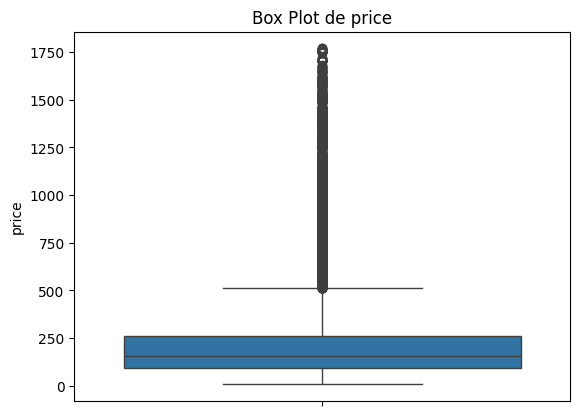

In [ ]:
# Graficamos el Box Plot de la variable price:
sns.boxplot(
    data = df_airbnb_LA_filtrado,
    y = 'price'
).set(ylabel = "price", title = "Box Plot de price")
plt.show()

Aplicamos una transformación logarítmica sobre el precio:

In [ ]:
df_airbnb_LA_regresion_lineal["log_price"] = np.log(df_airbnb_LA_regresion_lineal["price"])
df_airbnb_LA_regresion_lineal.drop(columns=["price"], axis=1, inplace=True)

#### Normalización

##### Z-score

Utilizamos la normalización Z-score para las variables cuantitativas.  

In [ ]:
scaler_z = StandardScaler()
cols_zscore = ["accommodates", "bathrooms", "bedrooms", "beds",
               "amenities_num", "minimum_nights", "maximum_nights",
               "review_scores_rating", "review_scores_value"]
df_airbnb_LA_regresion_lineal[cols_zscore] = scaler_z.fit_transform(df_airbnb_LA_regresion_lineal[cols_zscore])
df_airbnb_LA_regresion_lineal.head(2)

,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,review_scores_rating,review_scores_value,amenities_num,property_group_Private room,...,bathrooms_type_shared,area_Central LA,area_Gateway Cities,area_San Fernando Valley,area_San Gabriel Valley,area_Santa Catalina Island,area_Santa Clarita Valley,area_South Bay,area_Westside Cities,log_price
0,-1.162565,-0.613347,-0.604621,-0.829342,0.938288,0.361891,0.118803,0.321320,2.208521,True,...,True,True,False,False,False,False,False,False,False,4.700480
1,-1.162565,-0.613347,-0.604621,-0.829342,-0.605771,-1.056099,-1.091789,-1.330801,-1.152803,True,...,False,False,False,False,False,False,False,False,True,4.770685


### Entrenamiento del modelo

In [ ]:
features = df_airbnb_LA_regresion_lineal.columns.drop("log_price")
features_train, features_test, log_price_train, log_price_test = train_test_split(
    df_airbnb_LA_regresion_lineal[features],
    df_airbnb_LA_regresion_lineal["log_price"],
    random_state = 1,
    train_size = 0.80)

regresion_lineal = LinearRegression()
regresion_lineal.fit(features_train, log_price_train)

log_price_pred = regresion_lineal.predict(features_test)

metricas_regresion(np.exp(log_price_pred), np.exp(log_price_test))

MSE: 23761.91, RMSE: 154.15, MAE: 78.27, R2: 0.53


Realizamos un análisis de las variables más influyentes en el modelo mediante la comparación de los coeficientes. Establecimos un umbral de $50\%$ para el efecto en porcentaje sobre el precio (`cambio_%`) a partir del cual, si una variable supera ese valor, entonces es considerada influyente en la estimación de la variable `price`.

In [ ]:
coeficientes = pd.DataFrame({
    "variable": features,
    "coeficiente": regresion_lineal.coef_
}).sort_values(by="coeficiente", ascending=False)

coeficientes["cambio_%"] = (np.exp(coeficientes["coeficiente"]) - 1) * 100
coeficientes["abs_cambio_%"] = abs(coeficientes["cambio_%"])
coeficientes = coeficientes.sort_values(by="abs_cambio_%", ascending=False)

UMBRAL_CAMBIO_PORC = 50
variables_mas_influyentes = coeficientes[coeficientes["abs_cambio_%"] > UMBRAL_CAMBIO_PORC]
variables_mas_influyentes[["variable", "cambio_%"]]

,variable,cambio_%
21,area_Santa Catalina Island,290.278882
24,area_Westside Cities,102.063727
23,area_South Bay,94.916345
13,room_type_Hotel room,77.563247
17,area_Central LA,69.624356
19,area_San Fernando Valley,63.083578
9,property_group_Private room,-62.077781
14,room_type_Private room,53.679236


Notemos que la variable más influyente resultó ser `area_Santa Catalina Island` con `cambio_% = 298.126775`, que significa que si el alojamiento está en el área de Los Angeles de Santa Catalina Island, su precio esperado es alrededor de $298\%$ mayor que un alojamiento similar que no esté en esa área.

### Guardamos el modelo

In [ ]:
joblib.dump(regresion_lineal, 'regresion_lineal.joblib')

['regresion_lineal.joblib']

## XGBoost

In [ ]:
df_airbnb_LA_xgb = df_airbnb_LA_filtrado.copy()

### Elección de hiperparámetros

In [ ]:
features = df_airbnb_LA_xgb.columns.drop("price")
features_train, features_test, price_train, price_test = train_test_split(
    df_airbnb_LA_xgb[features],
    df_airbnb_LA_xgb["price"],
    random_state = 1,
    train_size = 0.80)
data_dmatrix = xgb.DMatrix(data=features_train, label=price_train)

Buscamos la cantidad de árboles `n_estimators`:

In [ ]:
results = xgb.cv(dtrain=data_dmatrix, nfold=5, params={"learning_rate": 0.1},
                 num_boost_round=200, metrics="rmse", early_stopping_rounds=10,
                 seed=1, shuffle=True)
print(results.tail(10))

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
99        115.488929        0.961100      137.705192       1.891882
100       115.315393        0.976295      137.660182       1.881573
101       115.216078        1.020246      137.661143       1.901076
102       115.096023        1.002999      137.627879       1.907898
103       114.973144        1.089584      137.643168       1.920322
104       114.825826        1.110842      137.632594       1.933837
105       114.706791        1.101525      137.641215       1.947765
106       114.563047        1.118859      137.633111       1.955390
107       114.448138        1.109175      137.596976       1.951281
108       114.353068        1.127527      137.565483       1.928313


In [ ]:
N_ESTIMATORS = 100

Buscamos la cantidad de *folds*:  

In [ ]:
results = []
for nf in range(2, 11):
    cv_results = xgb.cv(
        dtrain=data_dmatrix,
        params={"learning_rate": 0.1},
        nfold=nf,
        num_boost_round=N_ESTIMATORS,
        metrics="rmse",
        seed=1,
        shuffle=True
    )
    rmse_mean = cv_results["test-rmse-mean"].iloc[-1]
    results.append({
        "nfold": nf,
        "rmse_mean": rmse_mean
    })

results_df = pd.DataFrame(results).sort_values("rmse_mean")
results_df

,nfold,rmse_mean
5,7,137.077796
8,10,137.119580
4,6,137.131201
7,9,137.176807
6,8,137.184796
2,4,137.195161
3,5,137.705192
1,3,138.492591
0,2,139.601321


In [ ]:
NFOLD = 7

A continuación, utilizamos `GridSearchCV` para encontrar los valores óptimos de otros hiperparámetros:

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=1, n_estimators=20, n_jobs=-1)

grilla_parametros = {
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=grilla_parametros,
                           scoring='neg_root_mean_squared_error', cv=NFOLD, n_jobs=-1)

grid_search.fit(features_train, price_train)
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor score (CV):", -grid_search.best_score_)

Mejores hiperparámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7}
Mejor score (CV): 138.87200251675463


### Entrenamiento del modelo

Teniendo los hiperparámetros ahora podemos entrenar el modelo:

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators=N_ESTIMATORS, **grid_search.best_params_,
                             random_state=1, n_jobs=-1)
xgb_model.fit(features_train, price_train)
price_pred = xgb_model.predict(features_test)
metricas_regresion(price_pred, price_test)

MSE: 19175.48, RMSE: 138.48, MAE: 75.26, R2: 0.62


### Guardamos el modelo

In [ ]:
joblib.dump(xgb_model, 'xgb.joblib')

['xgb.joblib']

In [ ]:
joblib.dump(xgb_model, 'xgb.joblib')

['xgb.joblib']

## Random Forest Regressor con Cross-validation

In [ ]:
df_airbnb_LA_rf = df_airbnb_LA_filtrado.copy()

### Elección de hiperparámetros

In [ ]:
features = df_airbnb_LA_rf.columns.drop("price")
features_train, features_test, price_train, price_test = train_test_split(
    df_airbnb_LA_rf[features],
    df_airbnb_LA_rf["price"],
    random_state = 1,
    train_size = 0.80)
data_dmatrix = xgb.DMatrix(data=features_train, label=price_train)

Buscamos la cantidad de árboles `n_estimators`:

In [ ]:
n_estimators_list = [50, 100, 200]
results = []
for n in n_estimators_list:
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    scores = cross_val_score(rf, features_train, price_train, cv=5,
                             scoring='neg_root_mean_squared_error')
    results.append({
        "n_estimators": n,
        "rmse_mean": -np.mean(scores)
    })

results_df = pd.DataFrame(results).sort_values("rmse_mean")
results_df

,n_estimators,rmse_mean
2,200,140.607152
1,100,141.095299
0,50,141.655748


In [ ]:
N_ESTIMATORS = 100

Buscamos la cantidad de *folds*:

In [ ]:
results = []
for nf in range(2, 11):
    rf = RandomForestRegressor(n_estimators=20, random_state=1, n_jobs=-1)
    scores = cross_val_score(rf, features_train, price_train, cv=nf, scoring='neg_root_mean_squared_error')
    results.append({
        "nfold": nf,
        "rmse_mean": -np.mean(scores)
    })

results_df = pd.DataFrame(results).sort_values("rmse_mean")
results_df

,nfold,rmse_mean
7,9,143.462641
4,6,143.740508
3,5,143.814097
6,8,143.878460
5,7,143.902682
8,10,144.012271
2,4,144.412738
0,2,144.629343
1,3,145.367733


In [ ]:
NFOLD = 5

A continuación, utilizamos `GridSearchCV` para encontrar los valores óptimos de otros hiperparámetros:

In [ ]:
rf = RandomForestRegressor(n_estimators=20, random_state=1, n_jobs=-1)

grilla_parametros = {
    "max_depth": [None, 20, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [0.8, "sqrt"]
}

grid_search = GridSearchCV(estimator=rf, param_grid=grilla_parametros,
                           scoring='neg_root_mean_squared_error', cv=NFOLD, n_jobs=-1)

grid_search.fit(features_train, price_train)
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor score (CV):", -grid_search.best_score_)

Mejores hiperparámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Mejor score (CV): 138.90599759647193


### Entrenamiento del modelo

Teniendo los hiperparámetros ahora podemos entrenar el modelo:

In [ ]:
rf = RandomForestRegressor(n_estimators=N_ESTIMATORS, **grid_search.best_params_,
                           random_state=1, n_jobs=-1)
rf.fit(features_train, price_train)
price_pred = rf.predict(features_test)
metricas_regresion(price_pred, price_test)

MSE: 18517.15, RMSE: 136.08, MAE: 73.71, R2: 0.64


### Guardamos el modelo

In [ ]:
joblib.dump(rf, 'random_forest_cv.joblib')

['random_forest_cv.joblib']